In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 91% 204M/225M [00:01<00:00, 194MB/s]
100% 225M/225M [00:01<00:00, 156MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/flowers-recognition.zip",'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
import keras
from keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from keras.utils import plot_model
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

In [8]:
import os
import shutil
import random

# Veri setinin bulunduğu dizin
data_dir = "/content/flowers"

# Train ve test dizinlerini oluştur
train_dir = "train_data"
test_dir = "test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Veri setindeki sınıflar
classes = os.listdir(data_dir)

# Train ve test oranı
train_ratio = 0.80

# Her sınıf için veri setini train ve test olarak ayır
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Train ve test görüntülerini kopyala
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")

Train-test split completed successfully.


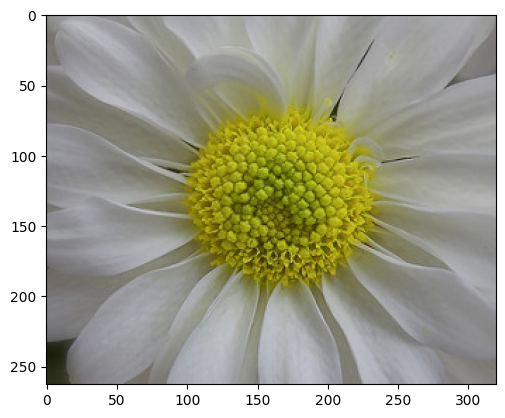

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/train_data/daisy/100080576_f52e8ee070_n.jpg") # Read the image data
plt.imshow(img) # Display the image
plt.show()

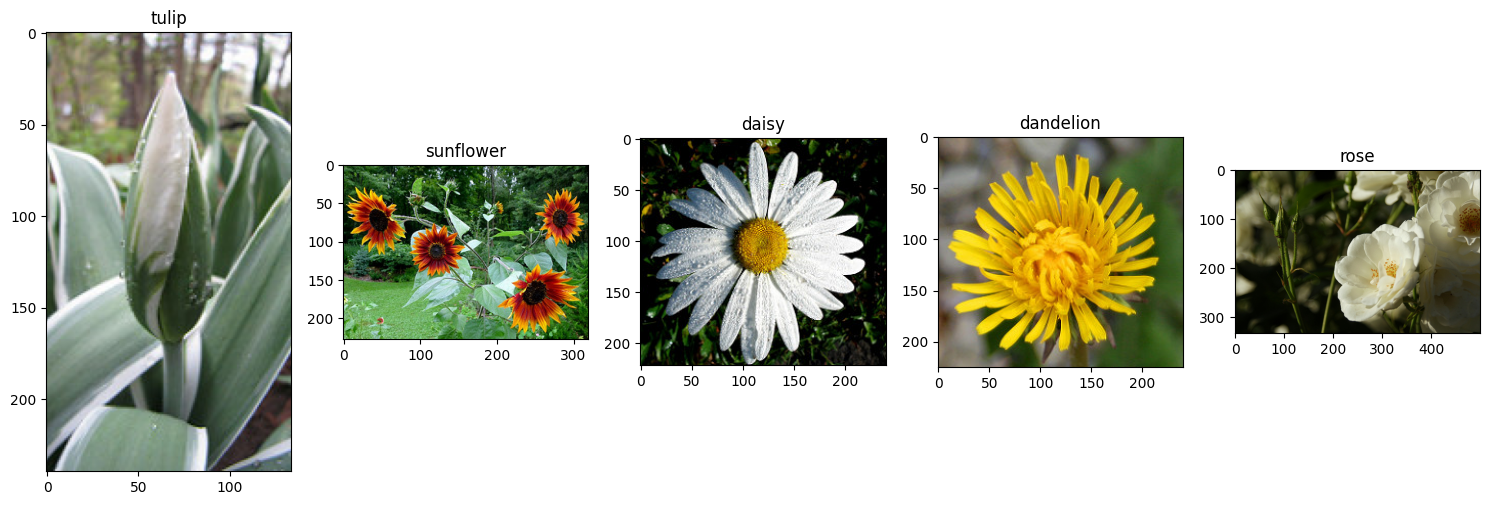

In [17]:
# Get the flower classes
classes = os.listdir(train_dir)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, len(classes), figsize=(15, 15))

# Iterate through the classes and display an image from each
for i, cls in enumerate(classes):
    # Get a list of images in the class directory
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)

    # Select the first image (you can change this to display a random image)
    img_path = os.path.join(class_dir, images[2])

    # Read the image data
    img = mpimg.imread(img_path)

    # Display the image on the corresponding subplot
    axes[i].imshow(img)
    axes[i].set_title(cls)
    # axes[i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

In [18]:
image_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [19]:
batch_size = 32
img_height = 256
img_width = 256

In [20]:
classes = ['daisy', 'rose', 'tulip', 'sunflower', 'dandelion']

In [21]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    test_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 2908 images belonging to 5 classes.
Found 467 images belonging to 5 classes.


In [22]:
image_shape = (256,256,3)

In [24]:
# Building the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape= image_shape),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

In [29]:
from keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss',patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [30]:
results = model.fit(training_data,epochs=20,validation_data=validation_data, callbacks=[early_stop,model_checkpoint])

Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 61.7490 - accuracy: 0.2586

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 80s 778ms/step - loss: 61.7490 - accuracy: 0.2586 - val_loss: 17.5525 - val_accuracy: 0.1756
Epoch 2/20
91/91 [==============================] - 57s 625ms/step - loss: 23.6012 - accuracy: 0.3257 - val_loss: 28.1990 - val_accuracy: 0.1370
Epoch 3/20
91/91 [==============================] - 55s 602ms/step - loss: 11.8757 - accuracy: 0.3937 - val_loss: 17.9258 - val_accuracy: 0.2056
Epoch 4/20
91/91 [==============================] - 67s 737ms/step - loss: 7.5063 - accuracy: 0.3776 - val_loss: 13.5600 - val_accuracy: 0.2398
Epoch 5/20
91/91 [==============================] - 67s 738ms/step - loss: 5.3541 - accuracy: 0.3968 - val_loss: 6.9446 - val_accuracy: 0.3062
Epoch 6/20
91/91 [==============================] - 69s 765ms/step - loss: 3.4024 - accuracy: 0.3999 - val_loss: 2.9298 - val_accuracy: 0.3340
Epoch 7/20
91/91 [==============================] - 55s 604ms/step - loss: 2.2630 - accuracy: 0.4298 - val_loss: 3.1650 - val_accuracy: 0.3148
Epo

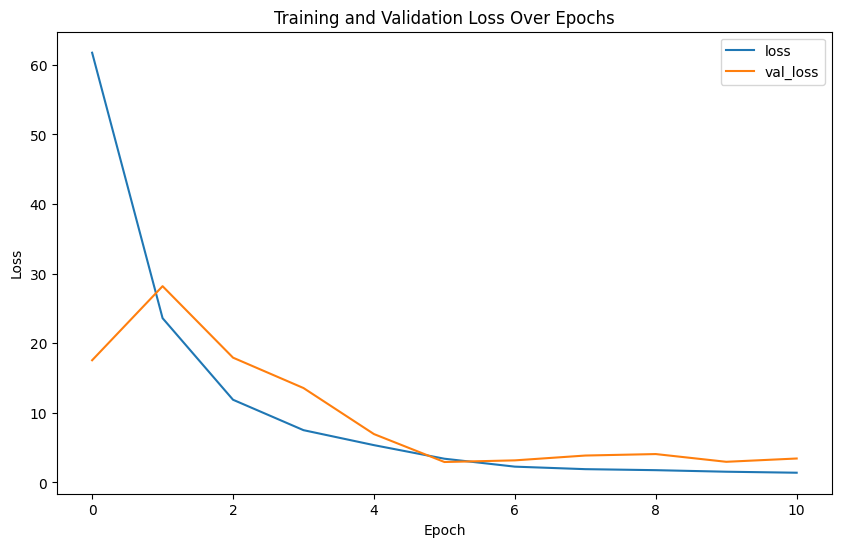

In [31]:
# Plotting the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(results.history['loss'], label="loss")
plt.plot(results.history['val_loss'], label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training and Validation Loss Over Epochs")
plt.show()

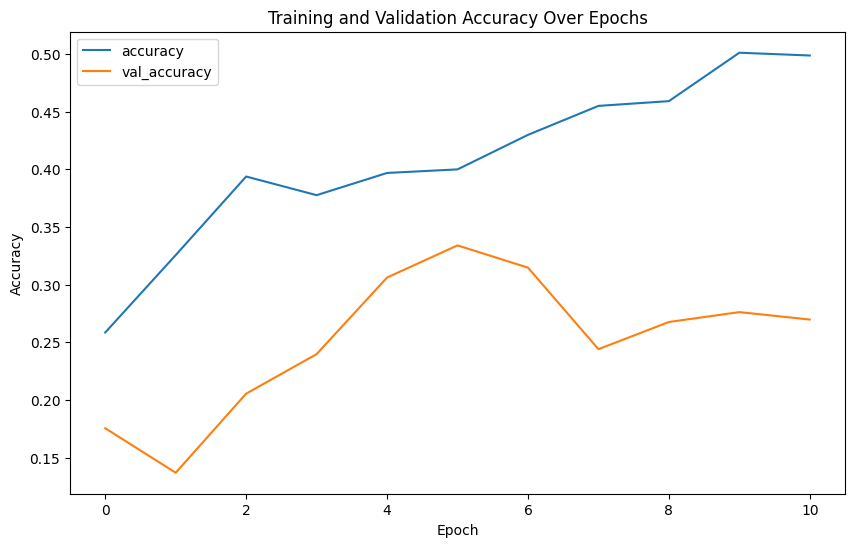

In [32]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(results.history['accuracy'], label="accuracy")
plt.plot(results.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training and Validation Accuracy Over Epochs")
plt.show()

### VGG 16

In [33]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape= image_shape)

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Defining the model
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
vgg_model.summary()

# Training the model
vgg_history = vgg_model.fit(
    training_data,epochs=20,validation_data=validation_data, callbacks=[early_stop,model_checkpoint]
)


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 58s 643ms/step - loss: 1.3376 - accuracy: 0.4477 - val_loss: 1.0572 - val_accuracy: 0.5889
Epoch 3/20
91/91 [==============================] - 58s 632ms/step - loss: 1.1646 - accuracy: 0.5251 - val_loss: 1.0150 - val_accuracy: 0.6231
Epoch 4/20
91/91 [==============================] - 58s 642ms/step - loss: 1.0346 - accuracy: 0.6131 - val_loss: 0.9515 - val_accuracy: 0.6210
Epoch 5/20
91/91 [==============================] - 57s 627ms/step - loss: 0.9923 - accuracy: 0.6252 - val_loss: 1.1602 - val_accuracy: 0.5375
Epoch 6/20
91/91 [==============================] - 58s 642ms/step - loss: 0.8937 - accuracy: 0.6723 - val_loss: 0.8702 - val_accuracy: 0.6510
Epoch 7/20
91/91 [==============================] - 57s 626ms/step - loss: 0.9054 - accuracy: 0.6486 - val_loss: 0.7448 - val_accuracy: 0.7259
Epoch 8/20
91/91 [==============================] - 59s 645ms/step - loss: 0.8471 - accuracy: 0.6785 - val_loss: 0.7287 - val_accuracy: 0.7430
Epoch 9/20

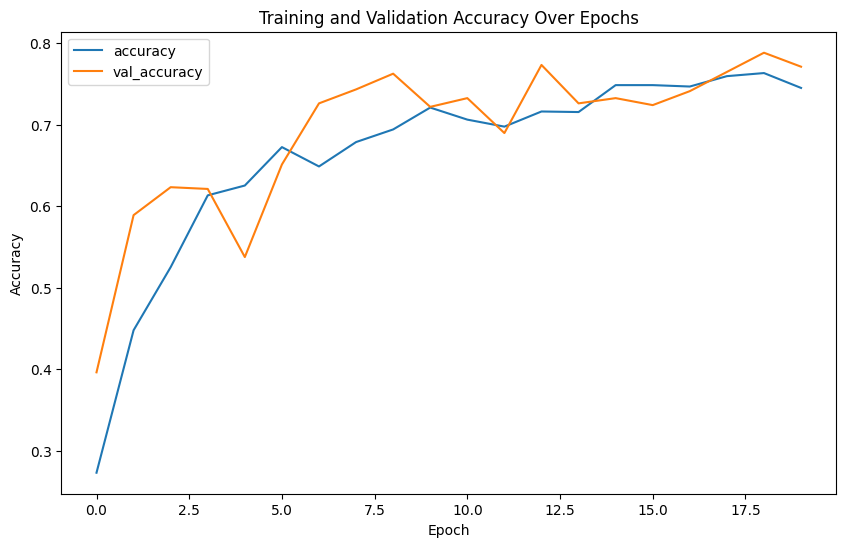

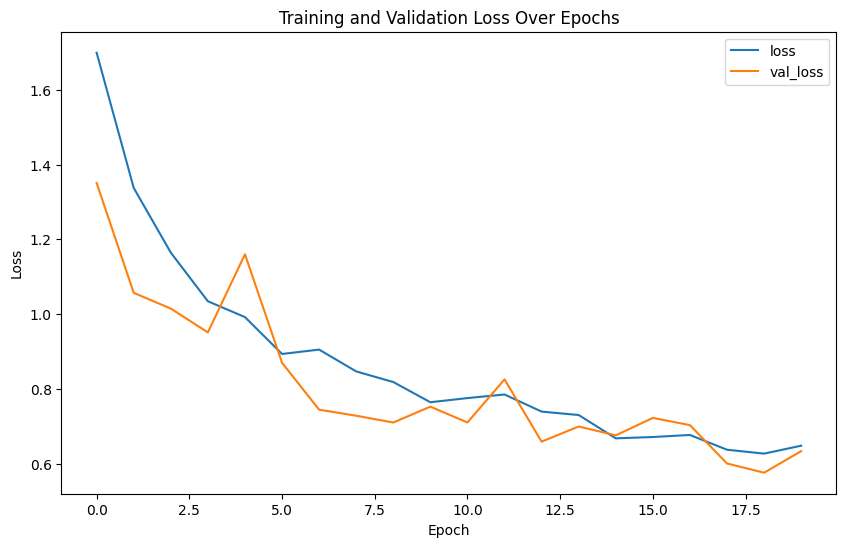

In [34]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(vgg_history.history['accuracy'], label="accuracy")
plt.plot(vgg_history.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training and Validation Accuracy Over Epochs")
plt.show()


# Plotting the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(vgg_history.history['loss'], label="loss")
plt.plot(vgg_history.history['val_loss'], label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training and Validation Loss Over Epochs")
plt.show()

### MobileNetV2 Model

In [ ]:
mobilenet_model = Sequential()

pretrained_model= keras.applications.MobileNetV2(include_top=False, input_shape=image_shape, pooling='avg', weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))


mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


mobilenet_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2916421 (11.13 MB)
Trainable params: 658437 (2.51 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
results = mobilenet_model.fit(training_data,epochs=15, validation_data=validation_data, callbacks=[early_stop])

Epoch 1/15
76/76 [==============================] - 208s 3s/step - loss: 1.5674 - accuracy: 0.4938 - val_loss: 0.7283 - val_accuracy: 0.6783
Epoch 2/15
76/76 [==============================] - 199s 3s/step - loss: 0.7519 - accuracy: 0.7250 - val_loss: 0.6087 - val_accuracy: 0.7674
Epoch 3/15
76/76 [==============================] - 197s 3s/step - loss: 0.6010 - accuracy: 0.7680 - val_loss: 0.4674 - val_accuracy: 0.8411
Epoch 4/15
76/76 [==============================] - 195s 3s/step - loss: 0.4656 - accuracy: 0.8205 - val_loss: 0.4601 - val_accuracy: 0.8333
Epoch 5/15
76/76 [==============================] - 198s 3s/step - loss: 0.4508 - accuracy: 0.8342 - val_loss: 0.4471 - val_accuracy: 0.8217
Epoch 6/15
76/76 [==============================] - 193s 3s/step - loss: 0.3547 - accuracy: 0.8681 - val_loss: 0.4903 - val_accuracy: 0.8178
Epoch 7/15
76/76 [==============================] - 195s 3s/step - loss: 0.3521 - accuracy: 0.8747 - val_loss: 0.3392 - val_accuracy: 0.8876
Epoch 8/15
76

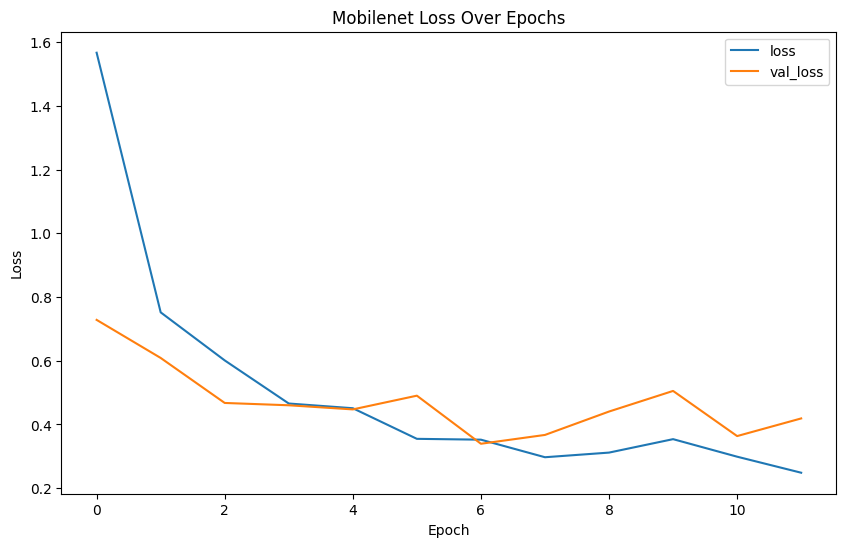

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(results.history['loss'], label="loss")
plt.plot(results.history['val_loss'], label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Mobilenet Loss Over Epochs")
plt.show()

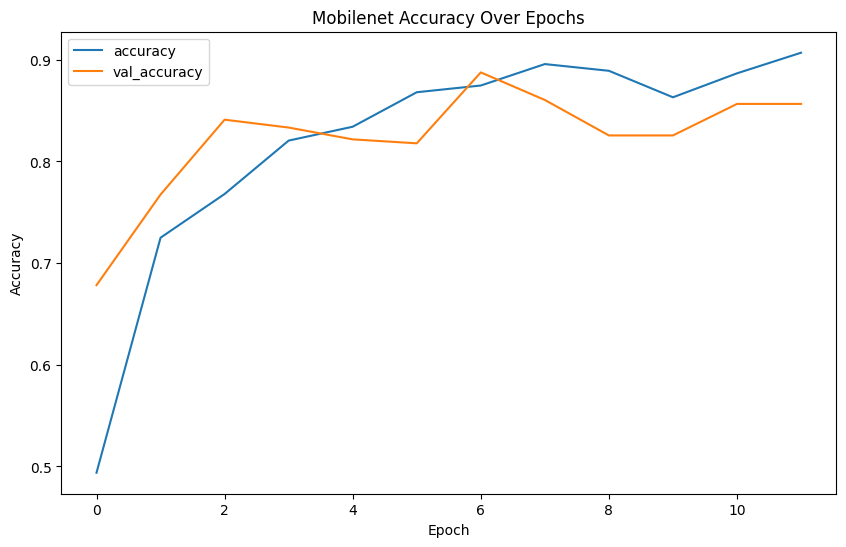

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(results.history['accuracy'], label="accuracy")
plt.plot(results.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Mobilenet Accuracy Over Epochs")
plt.show()

In [ ]:
# Save the model
mobilenet_model.save("/content/flowermodel.pkl")

# Download the saved model file
from google.colab import files
files.download("/content/flowermodel.pkl")

In [ ]:
import numpy as np
from keras.preprocessing import image

# Define a function to predict the label of an image
def predict_flower_label(model, img_path, class_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    prediction = model.predict(img_array)

    # Map predicted class probabilities to class labels
    predicted_label = class_names[np.argmax(prediction)]

    return predicted_label

# Example usage:
# Assuming 'model' is your trained CNN model
# Replace 'model_path' with the path to your trained model
# model_path = "path/to/your/model.h5"
# model = tf.keras.models.load_model(model_path)

# Replace 'img_path' with the path to the image you want to classify
img_path = "/content/test_sunflower.jpg"

# Define the class names
class_names = ['chamomile', 'tulip', 'rose', 'sunflower', 'dandelion']

# Get the predicted label
predicted_label = predict_flower_label(model, img_path, class_names)
print("Predicted Label:", predicted_label)